In [103]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [104]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["label", "message"])

In [105]:
data = pd.read_csv("sms_spam_collection.csv")
data

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [106]:
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 1)

(1115, 1)

(4457,)

(1115,)

In [107]:
#Display message counts
hams = data[(data['label'] == 'ham')]
spams = data[(data['label'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))



Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


# Trivial Classifier Questions

<ol>
<li>Describe a trivial classifier that could achieve at least an accuracy of 0.8.</li></br>
<p style="color:blue">An example of a trivial classifier that could achieve a least an accuracy of 0.8 is the DummyClassifier class that is in SKLearn.</p></br>
<li>How would this classifier make its classification?</li></br>
<p style="color:blue">This classfier would make its predictions based on the class that appeared the most. In this case, it would predict 'ham' for all values.</p></br>
<li>What accuracy would it get on your training data?</li></br>
<p style="color:blue">The accuracy of that model on the training data would be over 80%.</p></br>
<li>In addition to accuracy, what metric should you use to ensure that your classifier is better than a trivial one?</li></br>
<p style="color:blue">Another metric besides accuracy that I can use to ensure that my classifier works better than a trivial one is recall and precision metrics. </p></br>
<li>What score would your trivial classifier get on this training data?</li></br>
<p style="color:blue">The score this model would receive for the recall score for 'ham' messages would be 1 and the recall score for 'spam' would be 0. The precision score for the 'ham' messages would be 0.8659 and the precision score for the 'spam' messages would be 0.</p></br>
</ol>

# Selected Metrics 

The metrics that I chose to track alongside accuracy was precision and recall. I chose those two additional metrics because while accuracy can give a good idea on how the classification model is doing overall; it is not enough to get the whole picture. Precision and recall are both better metrics in terms of seeing how good a model can be if given data that it hasn't seen before.

Precision can be defined as the models ability to be correct when it says that something is right or positive. On the other hand, the recall is the ability of the model to be correct when it predicts that a value is negative.

For this example, if given a classifier that always chooses 'ham' for its predictions instead of 'spam', the accuracy of that model would be over 80% for the training data that would be presented to it. On the other hand, for metrics such as precision and recall, the results would not be as good. Therefore, my baseline for those metrics would be an accuracy of at least 86%, a precision score of at least 86%, and a recall score for 'spam' better than 0.

# Bayesian Model

In [108]:
nlp = spacy.load("en_core_web_sm")
def custom_spacy_tokenizer(text):
        doc = nlp(text)
        return [token.lemma_.lower().strip() for token in doc if not token.is_stop and not token.is_punct]

In [109]:
vectorizer = CountVectorizer(tokenizer=custom_spacy_tokenizer, strip_accents='unicode', lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train['message'])
vectorizer.get_feature_names_out()
X_test_vectorized = vectorizer.transform(X_test['message'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [110]:
display(X_train_vectorized.shape)
display(X_test_vectorized.shape)
display(y_train.shape)
display(y_test.shape)

(4457, 7158)

(1115, 7158)

(4457,)

(1115,)

In [111]:
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

# Bayesian Training Results

Training Cross Validation Metrics

In [112]:
metrics = {'Accuracy': 'accuracy', 'Precision (Macro)': 'precision_macro', 'Recall (Macro)': 'recall_macro'}

In [113]:
for key, value in metrics.items():
    bayesian_training_values = cross_val_score(classifier, X_train_vectorized, y_train, scoring=value, cv=5)
    print(f"Cross-validation {key} training scores: ", bayesian_training_values)
    np_bayesian_training_values = np.array(bayesian_training_values)
    average = np.mean(np_bayesian_training_values)
    stDev = np.std(np_bayesian_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.97757848 0.96973094 0.98204265 0.97530864 0.98316498]
0.98  +/-  0.0049 

Cross-validation Precision (Macro) training scores:  [0.9413858  0.92433479 0.95308123 0.9412951  0.96833148]
0.95  +/-  0.0146 

Cross-validation Recall (Macro) training scores:  [0.96593264 0.95084197 0.97203307 0.95376518 0.95829886]
0.96  +/-  0.0078 



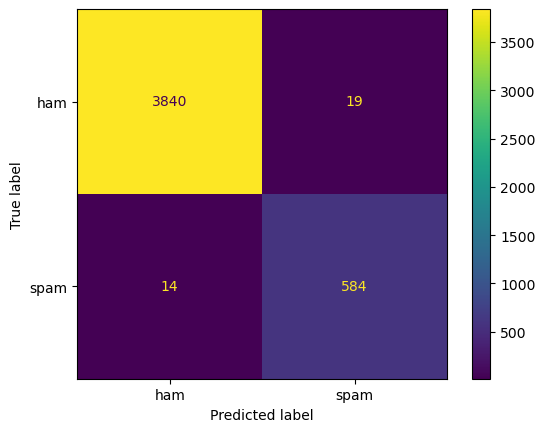

In [114]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_train_vectorized, y_train)

# Bayesian Testing Results

Testing Cross Validation Metrics

In [115]:
for key, value in metrics.items():
    bayesian_testing_values = cross_val_score(classifier, X_test_vectorized, y_test, scoring=value, cv=5)
    print(f"Cross-validation {key} testing scores: ", bayesian_testing_values)
    np_bayesian_testing_values = np.array(bayesian_testing_values)
    average = np.mean(np_bayesian_testing_values)
    stDev = np.std(np_bayesian_testing_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy testing scores:  [0.97757848 0.97757848 0.97757848 0.98654709 0.98654709]
0.98  +/-  0.0044 

Cross-validation Precision (Macro) testing scores:  [0.97061695 0.98737374 0.98737374 0.99234694 0.99234694]
0.99  +/-  0.008 

Cross-validation Recall (Macro) testing scores:  [0.92845716 0.91666667 0.91666667 0.95       0.95      ]
0.93  +/-  0.015 



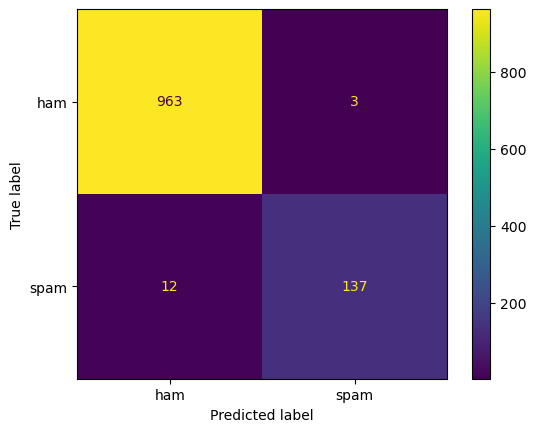

In [116]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(classifier, X_test_vectorized, y_test)

<ol>
<li>Did your classifier perform better than one that always predicted "ham"?</li></br>
<p style="color:blue">Yes, my model did perform better than one that always predicts "ham".</p></br>
<li>Were your testing metrics within the "bounds" set by your train/validation split (mean +/- std dev)?</li></br>
<p style="color:blue">Yes, from the results stated above, I do velieve that my testing metrics were within the "bounds" set by my train/validation split.</p></br>
<li>Would you use this "bare" classifier as a filter on your own messages?</li></br>
<p style="color:blue">No because I would like to see how it would score if given more data especially more 'spam' examples since the data was mostly 'ham' messages.</p></br>
</ol>

# Bayesian Training Learning Curve

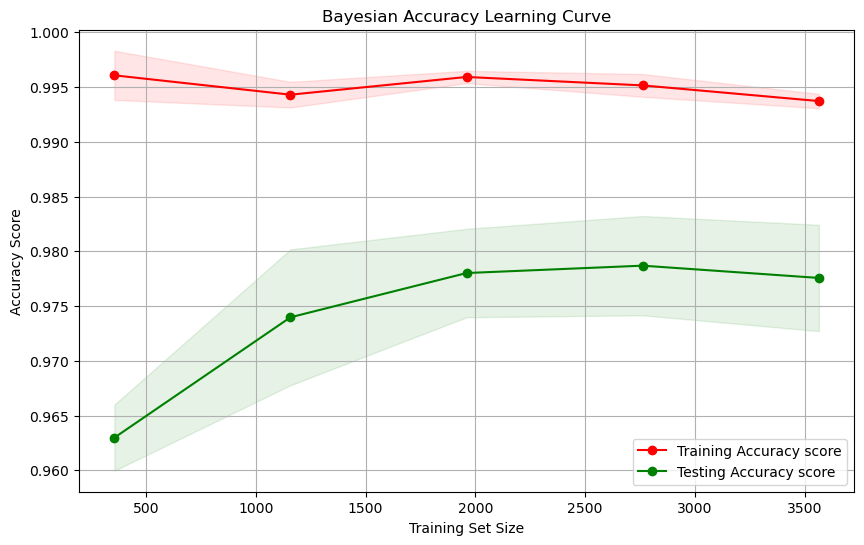

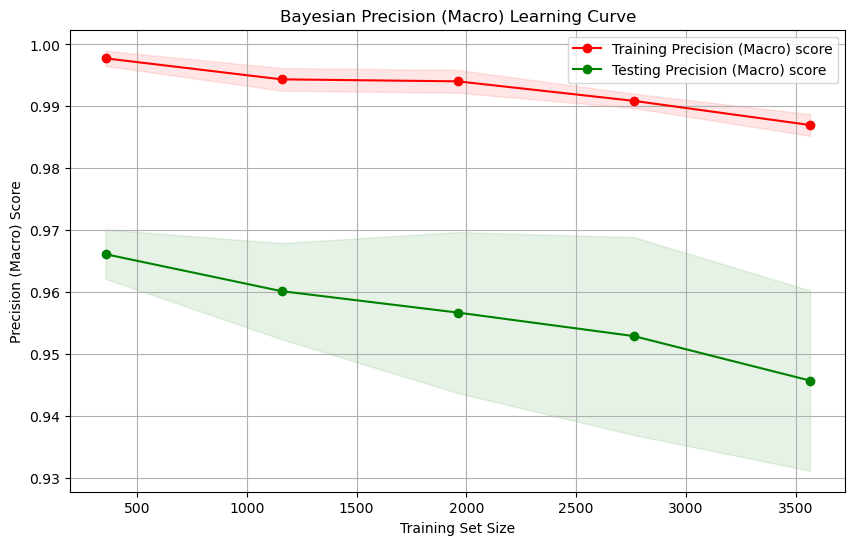

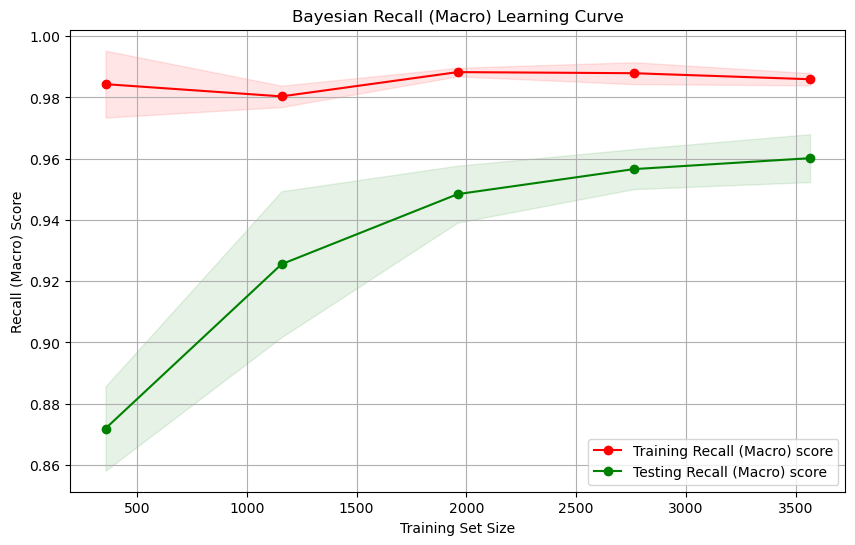

In [117]:
for key, value in metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_test_scores = learning_curve(
        classifier,
        X_train_vectorized,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_test_scores_mean = np.mean(bayesian_test_scores, axis=1)
    bayesian_test_scores_std = np.std(bayesian_test_scores, axis=1)

    # print("Bayesian Train Sizes: ", bayesian_train_sizes)
    # print("Bayesian Train Scores Mean: ", bayesian_train_scores_mean)
    # print("Bayesian Train Scores Std Dev: ", bayesian_train_scores_std)
    # print("Bayesian Test Scores Mean: ", bayesian_test_scores_mean)
    # print("Bayesian Test Scores Std Dev: ", bayesian_test_scores_std)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_test_scores_mean - bayesian_test_scores_std,
                    bayesian_test_scores_mean + bayesian_test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
             label=f"Training {key} score")
    plt.plot(bayesian_train_sizes, bayesian_test_scores_mean, 'o-', color="g",
             label=f"Testing {key} score")

    plt.legend(loc="best")
    plt.show()

<ol>
<li>Describe what this learning curve is telling you about how your algorithm might perform if given more data.</li></br>
<p style="color:blue">After analyzing the learning curves from above, I can conclude does perform better when given more data especially in terms of correcting 'False Negatives' which can be seen from the recall learning curve. On the other hand, I can see that the model does worse on situations with 'False Positives'. Therefore, I can conclude that my algorithm should be able to do better on being correct when it says that something is wrong/negative but will tend to do less good on being correct when it says something is right.</p></br>
<li>That is, does it appear to still be learning even as you get to larger input sizes?</li></br>
<p style="color:blue"</p>I do believe that my model is learning as it is receives larger input sizes.</br>
<li>If you built an App to classify spam SMS messages, would that App be able to learn/improve from your user's classification of messages?</li></br>
<p style="color:blue">In my honest opinion, I wouldn't use this as a model for an SMS spam classifier app mainly because of the precision issue that I stated earlier. The ability of my model to be correct when the value is actually not positive is one of the most crucial elements that the model needs to perform well on. So, I would most likely use another model.</p></br>
</ol>

# TFIDF Vectorization and Logistic Classifier

In [118]:
tdidf_vectorizer = TfidfVectorizer(tokenizer=custom_spacy_tokenizer)
X_train_tfidf_vectorized = tdidf_vectorizer.fit_transform(X_train['message'])
tdidf_vectorizer.get_feature_names_out()
X_test_tfidf_vectorized = tdidf_vectorizer.transform(X_test['message'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [119]:
# y_train = np.array(y_train)
# display(y_train)

# display(X_train)

In [120]:
pipeline = Pipeline(
    [
        ("clf", LogisticRegression())
    ]
)
param_grid = {
    "clf__penalty": ['l1', 'l2'], 
    "clf__C": [450, 475, 500, 515, 530], 
}

model = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

# logistic_pred_train = model.predict(X_train_tfidf_vectorized)
# logistic_pred_test = model.predict(X_test_tfidf_vectorized)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator

{'clf__C': 515, 'clf__penalty': 'l2'}

In [ ]:
log_classifier = LogisticRegression(penalty='l2', C=500)
log_classifier.fit(X_train_tfidf_vectorized, y_train)

{'clf__C': 515, 'clf__penalty': 'l2'}

# TFIDF Vectorization and Logistic Classifier Training Results

In [ ]:
logistic_training_values = cross_val_score(model, X_train_tfidf_vectorized, y_train, cv=5)
print("Cross-validation scores: ", logistic_training_values)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator

Cross-validation scores:  [0.98654709 0.98430493 0.97867565 0.97194164 0.97979798]


In [ ]:
np_logistic_training_values = np.array(logistic_training_values)
average = np.mean(np_logistic_training_values)
stDev = np.std(np_logistic_training_values)
print(average.round(2), " +/- ", stDev.round(4))

0.98  +/-  0.0051


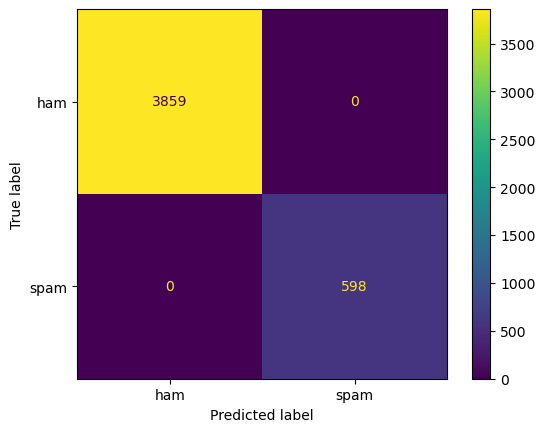

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_train_tfidf_vectorized, y_train)

# TFIDF Vectorization and Logistic Classifier Testing Results

In [ ]:
logistic_testing_values = cross_val_score(model, X_test_tfidf_vectorized, y_test, cv=5)
print("Cross-validation scores: ", logistic_testing_values)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator

Cross-validation scores:  [0.95515695 0.96860987 0.98206278 0.97757848 0.96412556]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator

In [ ]:
np_logistic_testing_values = np.array(logistic_testing_values)
average = np.mean(np_logistic_testing_values)
stDev = np.std(np_logistic_testing_values)
print(average.round(2), " +/- ", stDev.round(4))

0.97  +/-  0.0096


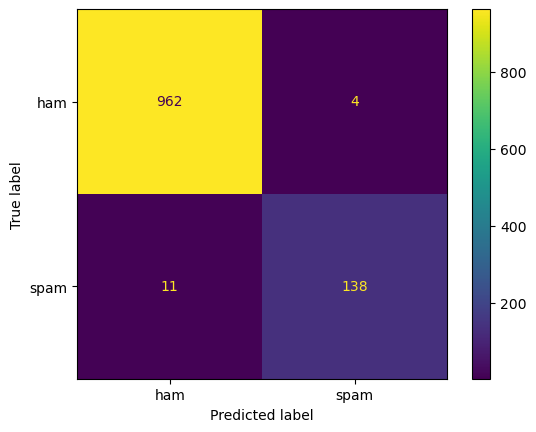

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf_vectorized, y_test)

# TFIDF Vectorization and Logistic Classifier Training Learning Curve

In [ ]:
logistic_train_sizes, logistic_train_scores, logistic_test_scores = learning_curve(
    model,
    X_train_tfidf_vectorized,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator

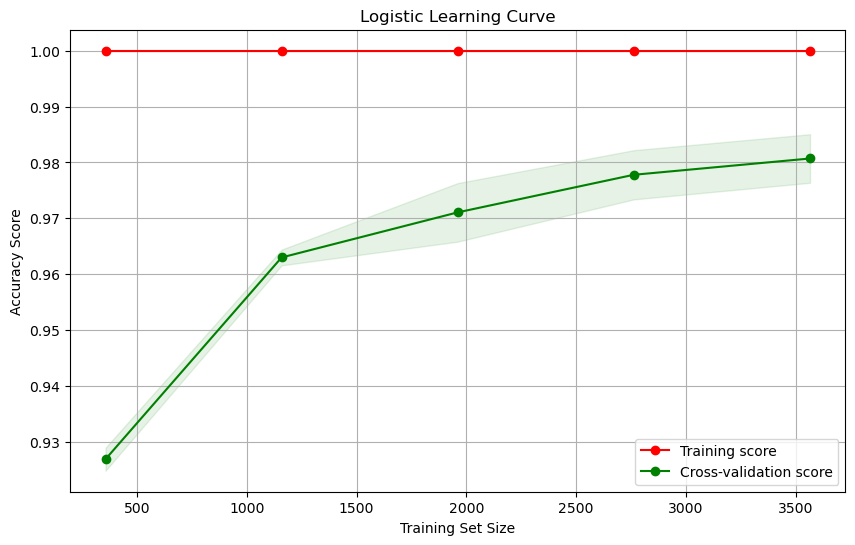

Exception ignored in: <function ResourceTracker.__del__ at 0x1026bdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107921bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102eb5bc0>
Traceback (most recent call last

In [ ]:
# Calculate mean and standard deviation for scores
logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
logistic_test_scores_mean = np.mean(logistic_test_scores, axis=1)
logistic_test_scores_std = np.std(logistic_test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Logistic Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(logistic_train_sizes, logistic_train_scores_mean - logistic_train_scores_std,
                 logistic_train_scores_mean + logistic_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(logistic_train_sizes, logistic_test_scores_mean - logistic_test_scores_std,
                 logistic_test_scores_mean + logistic_test_scores_std, alpha=0.1,
                 color="g")
plt.plot(logistic_train_sizes, logistic_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(logistic_train_sizes, logistic_test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Conclusions

Bayesian vs Logistic Results